In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. 데이터 로드

In [2]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [3]:
train.shape, test.shape, submission.shape

((45532, 77), (11383, 76), (11383, 1))

In [4]:
train.head(3)
test.head(3)
submission.head(3)

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,1,1,0,1,1,1,1,0,1,1


,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,736,2.0,2941,3.0,4621,1.0,4857,2.0,2550,...,0,1,0,0,1,0,1,0,1,1
1,3.0,514,2.0,1952,3.0,1552,3.0,821,4.0,1150,...,0,0,0,0,0,0,0,0,0,0
2,3.0,500,2.0,2507,4.0,480,2.0,614,2.0,1326,...,0,1,0,1,1,0,1,0,1,1


,voted
index,
0,0
1,0
2,0


# 2. EDA & 전처리

In [5]:
df = pd.concat([train, test])
df.shape

(56915, 77)

In [6]:
train.info

<bound method DataFrame.info of        QaA   QaE  QbA   QbE  QcA   QcE  QdA   QdE  QeA   QeE  ...  wr_04  \
index                                                         ...          
0      3.0   363  4.0  1370  5.0   997  1.0  1024  2.0  1577  ...      0   
1      5.0   647  5.0  1313  3.0  3387  5.0  2969  1.0  4320  ...      1   
2      4.0  1623  1.0  1480  1.0  1021  4.0  3374  5.0  1333  ...      1   
3      3.0   504  3.0  2311  4.0   992  3.0  3245  1.0   357  ...      0   
4      1.0   927  1.0   707  5.0   556  2.0  1062  1.0  1014  ...      1   
...    ...   ...  ...   ...  ...   ...  ...   ...  ...   ...  ...    ...   
45527  2.0  1050  5.0   619  4.0   328  1.0   285  1.0   602  ...      1   
45528  2.0   581  3.0  1353  4.0  1164  1.0   798  3.0  1680  ...      1   
45529  4.0   593  1.0   857  1.0  1047  4.0  1515  5.0  1690  ...      1   
45530  1.0   747  3.0  1331  4.0   892  2.0  1281  1.0  1328  ...      1   
45531  3.0   496  5.0  1827  5.0   754  3.0  1117  1.0  

## Missing Value

In [7]:
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

## Target 분포

<AxesSubplot:ylabel='voted'>

<AxesSubplot:xlabel='voted', ylabel='count'>

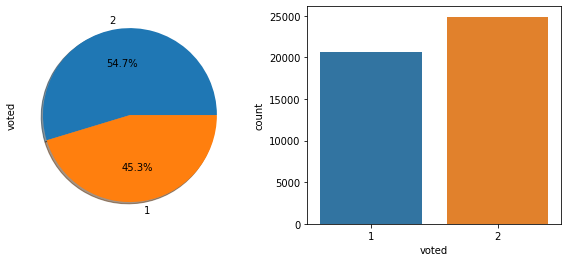

In [8]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

train['voted'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
sns.countplot('voted', data=train, ax=ax[1])

plt.show()

# 균일

## Outlier

In [9]:
test.familysize.max(), test.familysize.mean(), train[train.familysize < 30]['familysize'].mean()

(23, 2.5790213476236494, 2.5933353835339603)

In [10]:
train[train.familysize > 20]['familysize'].value_counts().sort_values(ascending=False)

44            3
21            2
34            1
100           1
999           1
30            1
2147483647    1
Name: familysize, dtype: int64

In [11]:
train.loc[train[train.familysize > 25].index, 'familysize'] = 2.6

In [12]:
train['familysize'].value_counts()

2.0     17918
3.0     11256
1.0      6535
4.0      4907
5.0      1962
0.0      1217
6.0       838
7.0       387
8.0       221
9.0       126
10.0       59
11.0       39
12.0       21
13.0       11
14.0        9
2.6         8
15.0        8
17.0        3
21.0        2
16.0        2
20.0        2
18.0        1
Name: familysize, dtype: int64

## 인코딩

In [13]:
#age_group, gender, race, religion
train['age_group'] = train['age_group'].str.replace('s','').astype('int')
train['gender']= pd.factorize(train['gender'])[0]
train['race']=pd.factorize(train['race'])[0]
train['religion']=pd.factorize(train['religion'])[0]

test['age_group'] = test['age_group'].str.replace('s','').astype('int')
test['gender']=pd.factorize(test['gender'])[0]
test['race']=pd.factorize(test['race'])[0]
test['religion']=pd.factorize(test['religion'])[0]

### One-hot

In [14]:
train = pd.get_dummies(train, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
train

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_09_0,wr_09_1,wr_10_0,wr_10_1,wr_11_0,wr_11_1,wr_12_0,wr_12_1,wr_13_0,wr_13_1
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,1,0,0,1,1,0,0,1,0,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,0,0,1,1,0,0,1,0,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,0,1,0,1,1,0,0,1,0,1
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,...,1,0,0,1,1,0,0,1,0,1
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,...,1,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,602,...,0,1,0,1,1,0,0,1,0,1
45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,1680,...,0,1,0,1,1,0,0,1,0,1
45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,1690,...,1,0,0,1,1,0,0,1,0,1


In [15]:
test = pd.get_dummies(test, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
test

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_09_0,wr_09_1,wr_10_0,wr_10_1,wr_11_0,wr_11_1,wr_12_0,wr_12_1,wr_13_0,wr_13_1
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,736,2.0,2941,3.0,4621,1.0,4857,2.0,2550,...,1,0,0,1,1,0,0,1,0,1
1,3.0,514,2.0,1952,3.0,1552,3.0,821,4.0,1150,...,1,0,1,0,1,0,1,0,1,0
2,3.0,500,2.0,2507,4.0,480,2.0,614,2.0,1326,...,1,0,0,1,1,0,0,1,0,1
3,1.0,669,1.0,1050,5.0,1435,2.0,2252,5.0,2533,...,0,1,0,1,0,1,0,1,0,1
4,2.0,499,1.0,1243,5.0,845,2.0,1666,2.0,925,...,1,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,5.0,427,5.0,1066,5.0,588,1.0,560,2.0,1110,...,1,0,0,1,1,0,0,1,0,1
11379,1.0,314,5.0,554,5.0,230,1.0,956,2.0,1173,...,0,1,0,1,0,1,0,1,0,1
11380,1.0,627,2.0,799,1.0,739,2.0,1123,1.0,829,...,1,0,0,1,1,0,0,1,0,1


In [18]:
train.shape, test.shape
train.columns.values
test.columns.values

((45532, 202), (11383, 201))

array(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA',
       'QeE', 'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE',
       'QjA', 'QjE', 'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA',
       'QnE', 'QoA', 'QoE', 'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE',
       'QsA', 'QsE', 'QtA', 'QtE', 'familysize', 'voted', 'age_group_10',
       'age_group_20', 'age_group_30', 'age_group_40', 'age_group_50',
       'age_group_60', 'age_group_70', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'engnat_0',
       'engnat_1', 'engnat_2', 'gender_0', 'gender_1', 'hand_0', 'hand_1',
       'hand_2', 'hand_3', 'married_0', 'married_1', 'married_2',
       'married_3', 'race_0', 'race_1', 'race_2', 'race_3', 'race_4',
       'race_5', 'race_6', 'religion_0', 'religion_1', 'religion_2',
       'religion_3', 'religion_4', 'religion_5', 'religion_6',
       'religion_7', 'religion_8', 'religion_9', 'religion_10',
       'religion_11', 'tp01_0', 'tp

array(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA',
       'QeE', 'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE',
       'QjA', 'QjE', 'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA',
       'QnE', 'QoA', 'QoE', 'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE',
       'QsA', 'QsE', 'QtA', 'QtE', 'familysize', 'age_group_10',
       'age_group_20', 'age_group_30', 'age_group_40', 'age_group_50',
       'age_group_60', 'age_group_70', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'engnat_0',
       'engnat_1', 'engnat_2', 'gender_0', 'gender_1', 'hand_0', 'hand_1',
       'hand_2', 'hand_3', 'married_0', 'married_1', 'married_2',
       'married_3', 'race_0', 'race_1', 'race_2', 'race_3', 'race_4',
       'race_5', 'race_6', 'religion_0', 'religion_1', 'religion_2',
       'religion_3', 'religion_4', 'religion_5', 'religion_6',
       'religion_7', 'religion_8', 'religion_9', 'religion_10',
       'religion_11', 'tp01_0', 'tp01_1', 't

# 3. 모델 학습

In [19]:
from pycaret.classification import *

In [20]:
import gc
gc.collect()

36

In [23]:
%%time
clf = setup(data = train, target = 'voted')

Setup Succesfully Completed!


,Description,Value
0,session_id,7423
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45532, 202)"
4,Missing Values,False
5,Numeric Features,201
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 34.9 s


In [24]:
%%time
best_3 = compare_models(sort = 'AUC', n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6913,0.7613,0.6374,0.7595,0.6930,0.3873,0.3934,31.0873
1,CatBoost Classifier,0.6911,0.7607,0.6536,0.7495,0.6982,0.3850,0.3888,44.4901
2,Light Gradient Boosting Machine,0.6915,0.7605,0.6436,0.7561,0.6953,0.3871,0.3923,3.1384
3,Linear Discriminant Analysis,0.6889,0.7585,0.6609,0.7420,0.6991,0.3793,0.3821,2.7652
4,Extra Trees Classifier,0.6890,0.7571,0.6416,0.7531,0.6929,0.3820,0.3871,4.1656
5,Ada Boost Classifier,0.6879,0.7535,0.6541,0.7442,0.6962,0.3780,0.3814,7.1556
6,Extreme Gradient Boosting,0.6725,0.7426,0.6599,0.7183,0.6878,0.3447,0.3461,20.0032
7,Random Forest Classifier,0.6536,0.7112,0.6029,0.7183,0.6555,0.3124,0.3173,0.5154
8,Decision Tree Classifier,0.6095,0.6062,0.6411,0.6435,0.6423,0.2124,0.2124,2.9085
9,Naive Bayes,0.4546,0.5430,0.0217,0.5290,0.0414,-0.0012,-0.0048,0.1806


In [25]:
best_3

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=7423, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=3

In [26]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6969,0.7651,0.6486,0.7618,0.7007,0.3978,0.4031
1,0.6993,0.7689,0.6529,0.7630,0.7037,0.4022,0.4072
2,0.6884,0.7617,0.6408,0.7527,0.6923,0.3808,0.3859
3,0.6952,0.7651,0.6439,0.7617,0.6979,0.3946,0.4003
4,0.6861,0.7550,0.6313,0.7545,0.6874,0.3771,0.3831
Mean,0.6932,0.7631,0.6435,0.7587,0.6964,0.3905,0.3959
SD,0.0051,0.0047,0.0074,0.0043,0.0058,0.0098,0.0096


In [29]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6989,0.7735,0.6456,0.7669,0.7011,0.4022,0.4083


In [30]:
final_model = finalize_model(blended)

In [31]:
final_model

VotingClassifier(estimators=[('Gradient Boosting Classifier_0',
                              GradientBoostingClassifier(ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                  

In [32]:
predictions = predict_model(final_model, data = test)

In [33]:
submission['voted'] = predictions['Score']

In [34]:
submission.to_csv('output/20200928-2.csv')

## train, valid 데이터

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('voted', axis = 1), train['voted'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

## 하이퍼파라미터 튜닝

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, plot_importance

colsample_bytree': 0.9606396547156734
, 'max_bin': 164.7465545875555
, 'max_depth': 11.107229265820779
, 'min_child_samples': 198.98606348612637
, 'min_child_weight': 41.32364031573033
, 'num_leaves': 49.45519154750152
, 'reg_alpha': 0.8758415725587487
, 'reg_lambda': 8.299355787002883
, 'subsample': 0.6598579157665245}}

In [ ]:
# parameter 별로 search할 범위를 설정. 
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (10, 100), 
    'min_child_samples': (10, 500), 
    'min_child_weight':(1, 100),
    'subsample':(0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'max_bin':(10, 1000),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

In [ ]:
def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        #"n_estimators":500, "learning_rate":0.02,
        "n_estimators":1000, "learning_rate":0.001,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    valid_proba = lgb_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, valid_proba)
    
    return roc_auc   

In [ ]:
import gc
gc.collect()

In [ ]:
%%time
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_roc_eval,bayesian_params , random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=10, n_iter=50)

In [ ]:
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

* test_size=0.3
{'target': 0.7655615473679408, 'params': {'colsample_bytree': 0.737265320016441, 'max_bin': 30.378649352844423, 'max_depth': 15.699098521619943, 'min_child_samples': 417.8968939922066, 'min_child_weight': 22.02157195714934, 'num_leaves': 26.364247048639054, 'reg_alpha': 9.178391447573157, 'reg_lambda': 3.043118187352418, 'subsample': 0.5722807884690141}}

- outlier 삭제 
{'target': 0.7652209584768751, 'params': {'colsample_bytree': 0.5703824815639528, 'max_bin': 15.404309116854074, 'max_depth': 13.17919661428763, 'min_child_samples': 24.998278489695448, 'min_child_weight': 97.74061068693372, 'num_leaves': 99.35614131954165, 'reg_alpha': 1.2926370490809749, 'reg_lambda': 1.1059679925299122, 'subsample': 0.4274854420066033}}

- outlier 2.6 
{'target': 0.7655617202045278, 'params': {'colsample_bytree': 0.737265320016441, 'max_bin': 30.378649352844423, 'max_depth': 15.699098521619943, 'min_child_samples': 417.8968939922066, 'min_child_weight': 22.02157195714934, 'num_leaves': 26.364247048639054, 'reg_alpha': 9.178391447573157, 'reg_lambda': 3.043118187352418, 'subsample': 0.5722807884690141}}

In [ ]:
clf = LGBMClassifier(
        n_jobs=-1
        ,nthread=4
        ,n_estimators=1000
        ,learning_rate=0.02
        ,max_depth = 16
        ,num_leaves=47
        ,colsample_bytree=0.56
        ,subsample=0.55
        ,max_bin=30
        ,reg_alpha=0.23
        ,reg_lambda=0.03
        ,min_child_weight=70
        ,min_child_samples=169
        ,silent=-1
        ,verbose=-1
        ,random_state=42
        )

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
eval_metric= 'auc', verbose= 100, early_stopping_rounds= 50)

In [ ]:
plot_importance(clf, figsize=(16, 32))

# 4. 예측

In [ ]:
pred_y  = clf.predict(test)

In [ ]:
submission['voted'] = pred_y 

In [ ]:
submission

# 5. 제출

In [ ]:
submission.to_csv('output/20200928-1.csv')